In [ ]:
from date_extractor import extract_date
from datetime import date
from datetime import datetime

import numpy as np
import pandas as pd
import itertools

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_excel('/home/amindo/Desktop/Summer Camp Task Data.xlsx')

In [ ]:
df.info()

# خطاهای جزئی

## خطای جزئی ۱

In [6]:
df_temp = df.groupby('source_event_id').apply(lambda x:'both' if x.action.nunique()==2 else ('click' if 'click_post' in  x.action.unique() else 'load')).reset_index()
df_temp.rename(columns = {0:'percent'},inplace = True)
all_percent =df_temp['percent'].value_counts(normalize =True)
all_percent

both     0.413053
click    0.343802
load     0.243145
Name: percent, dtype: float64

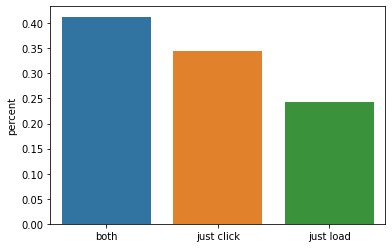

In [7]:
ax = sns.barplot(x=['both','just click','just load'], y=all_percent)


## خطای جزئی ۲

In [8]:
df_temp =df.loc[df['action']=='load_post_page']
df_temp = df_temp.groupby('source_event_id').post_page_offset.agg(n_unique = ('nunique'),maxx =('max')).reset_index()
df_temp.loc[(df_temp.n_unique - df_temp.maxx) != 1].shape[0]

632

## خطای جزئی ۳

In [9]:
print(df.loc[df.duplicated()].shape[0])
df.drop_duplicates(inplace = True)

67


### حذف کوئری های با بیش از یک سرچ

In [10]:
df_temp = df.sort_values('created_at')
df_temp = df_temp.loc[df_temp.action == 'load_post_page']
df_temp =df_temp.groupby('source_event_id')['post_page_offset'].apply(lambda x:((np.diff(x) <= 0.0 ).sum())).reset_index()
list1 = list(df_temp.loc[df_temp.post_page_offset != 0].source_event_id)
df = df.loc[ ~df.source_event_id.isin(list1)]

In [14]:
df.source_event_id.nunique()

14077

## خطای جزئی ۴

In [16]:
df_temp = df.sort_values('created_at')
df_temp = df_temp.loc[df_temp.action == 'click_post']
df_temp = df_temp.groupby('source_event_id')['created_at'].apply(lambda x:(np.absolute(np.diff(x)) < 200).sum() ).reset_index()
df_temp.created_at.value_counts()

0    10643
1        9
Name: created_at, dtype: int64

## خطای جزئی ۵

In [17]:
df_temp = df.groupby('source_event_id')['device_id'].apply(lambda x:x.isnull().sum()).reset_index()
df_temp.loc[df_temp['device_id'] >0].shape[0]


221

###  یک فعالیت وجود دارد که پست ایندکس دارد ولی توکنش ذخیره نشده است

In [18]:
in1 = df.loc[(df['post_index_in_post_list'].notnull()) & (df['post_token'].isnull())].index[0]
df.drop(in1,inplace = True)

### برای راحتی کار یک ستون برای تعداد توکن ها اضافه میکنیم

In [19]:
df['n_tokens'] = df.tokens.str.count(',') + 1

# سوال ۲

### dark query percent

In [20]:
def p_return(df1,threshhold=10):
    df_temp = df1[df1.groupby('source_event_id')['post_index_in_post_list'].transform('max') <threshhold]
    df_temp = df_temp.groupby('source_event_id').apply(lambda x:( x.n_tokens.max() >=threshhold or x.post_page_offset.max() >0 )).reset_index()    
    t = df_temp[0].value_counts(normalize = True)[False]
    return t

In [62]:
def dark_query_percent(df,threshhold,mode):
    if threshhold < 24 : 
        n = df.source_event_id.nunique()
        
        df_temp = df[df.groupby('source_event_id')['post_page_offset'].transform('count') ==0]
        a30 = df_temp[df_temp.groupby('source_event_id')['post_index_in_post_list'].transform('max') <threshhold].source_event_id.nunique()       
        print(a30)
        df_temp = df[df.groupby('source_event_id')['post_index_in_post_list'].transform('count') ==0]
        a20 = df_temp.groupby('source_event_id').apply(lambda x:(x.n_tokens.max() >= threshhold) or (x.post_page_offset.max() >0) ).value_counts().loc[False]
        print(a20)
        df1 = df[df.groupby('source_event_id').action.transform('nunique') ==2]
        print(df1.source_event_id.nunique())
        a10 = df1.groupby('source_event_id').apply(lambda x:(x.n_tokens.max() >= threshhold) or (x.post_page_offset.max() >0)).value_counts().loc[False]
        print(a10)
        if mode == 'with estimation':
            t = p_return(df1,threshhold)
            return (a10 + a20 + t*a30)/(n)
        elif mode =='no estimation':
            return (a10 + a20)/(n - a30)
        else:
            print('This information is not enough for proper resault')

###  های مختلف بدون تخمینthresholdنمودار برای 

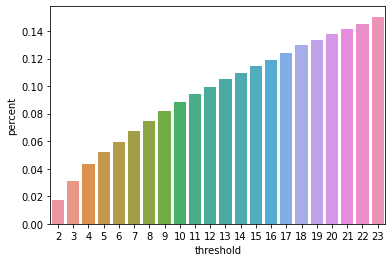

In [22]:
lst1 = []
lst2 = list(range(2,24))
for i in range(2,24):
    lst1.append(dark_query_percent(df,i,'no estimation'))
df_temp = pd.DataFrame(list(zip(lst1, lst2)),
               columns =['percent', 'threshold'])
ax = sns.barplot(x='threshold',y='percent',data = df_temp)

###  های مختلف با تخمینthresholdنمودار برای  

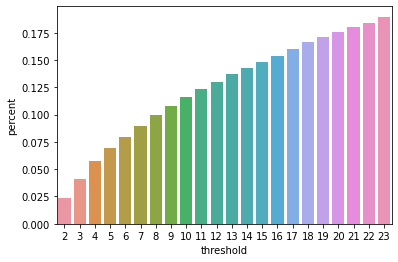

In [23]:
lst1 = []
lst2 = list(range(2,24))
for i in range(2,24):
    lst1.append(dark_query_percent(df,i,'with estimation'))
df_temp = pd.DataFrame(list(zip(lst1, lst2)),
               columns =['percent', 'threshold'])
ax = sns.barplot(x='threshold',y='percent',data = df_temp)

### query bounce rate

In [24]:
 def query_bounce_rate(df):
    n_unique = df['source_event_id'].nunique()
    n_ziro_click =df.loc[df['action'] == 'click_post'].source_event_id.nunique()
    return " {:.0%}  ". format(1 - (n_ziro_click/n_unique))

In [25]:
query_bounce_rate(df)

' 24%  '

# سوال ۳

In [26]:
def met1(df):
    df_temp = df.loc[df.groupby('source_event_id')['post_page_offset'].transform('count') > 0] .reset_index()
    df_temp = df_temp.groupby('source_event_id').agg({'post_index_in_post_list':'nunique','post_page_offset':'max','n_tokens':'min'}).reset_index()
    df_temp['met1'] = (df_temp['post_index_in_post_list']) / (24*df_temp['post_page_offset'] + df_temp['n_tokens'] )
    df_temp.drop(['post_index_in_post_list','post_page_offset','n_tokens'],inplace = True,axis = 1)
    return(df_temp)    

In [28]:
df_temp = met1(df)
meann = np.mean(df_temp.met1)
meann

0.08379808937524362

In [ ]:
def met2(df):
    df_temp = df.sort_values('created_at',ascending = True)
    df_temp = df_temp.loc[df['action'] == 'click_post']
    df_temp = df_temp.groupby(['source_event_id'])['post_index_in_post_list'].first().reset_index()
    df_temp.rename(columns = {'post_index_in_post_list' : 'met2'},inplace = True) 
    return df_temp

In [ ]:
def met3(df):
    df_temp = df.groupby('source_event_id')['post_index_in_post_list'].agg(['max','nunique']).reset_index()
    df_temp['met3'] = (df_temp['max'])/df_temp['nunique']
    df_temp.drop(['max','nunique'],inplace = True,axis = 1)
    return df_temp

In [47]:
def met4(df,threshhold=3):
    df_temp =df.groupby('source_event_id')['post_index_in_post_list'].min().reset_index()
    df_temp['met4'] = 0*df_temp.shape[0]
    df_temp['met4'].loc[df_temp['post_index_in_post_list'] <=threshhold] = 1
    df_temp.drop('post_index_in_post_list',inplace = True,axis =1) 
    return df_temp

In [ ]:
def metric_data(df):
    df_all_metrics = pd.merge(met1(df),met2(df),on = 'source_event_id',how = 'outer')
    df_all_metrics = pd.merge(df_all_metrics,met3(df),on = 'source_event_id',how = 'outer')
    df_all_metrics = pd.merge(df_all_metrics,met4(df),on = 'source_event_id',how = 'outer')
    return df_all_metrics


In [ ]:
df_all_metrics = metric_data(df)